In [1]:
import gc

# Uncomment below cell to use GPU for computation

In [2]:
import tensorflow as tf

physical_device = tf.config.experimental.list_physical_devices('GPU')
print('No. of GPU: ', len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

No. of GPU:  1


# <span style = 'background: Red'> CNN for image classifiaction </span>

## Importing training dataset 

In [3]:
train_folder =  'train'

In [4]:
# pip install matplotlib

In [5]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

## Viewing some random images from the training folder

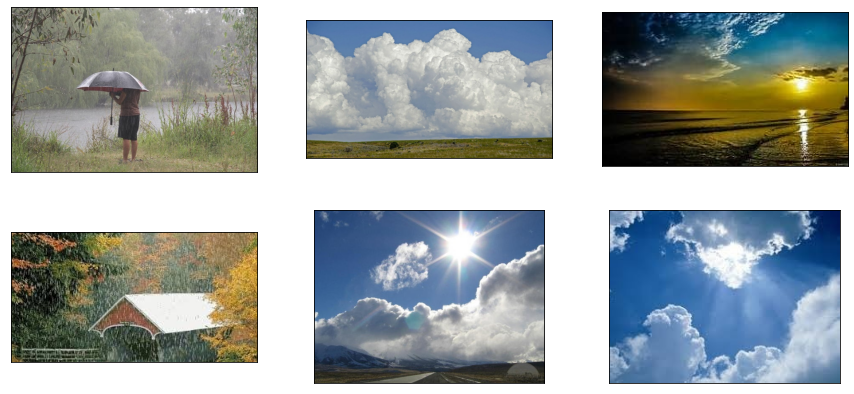

In [6]:
files = np.random.choice(os.listdir(train_folder), 6)

fig, axes = plt.subplots(2,3, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
    
axes = axes.flat

for file, ax in list(zip(files, axes)) :
    img_path = os.path.join(train_folder, file)
    img = mpimg.imread(img_path)
    ax.imshow(img)

## Loading images and labels from the training folder and dataset

In [7]:
# pip install pandas

In [8]:
import pandas as pd

df_targets = pd.read_csv('Training_set.csv')
df_targets.head()

,filename,label
0,Image_1.jpg,sunrise
1,Image_2.jpg,shine
2,Image_3.jpg,cloudy
3,Image_4.jpg,shine
4,Image_5.jpg,sunrise


In [9]:
# df_targets[df_targets['filename'] == 'Image_1.jpg']['label'].values[0]

In [10]:
# pip install opencv-python

In [11]:
import cv2 

In [12]:
image_data = []
image_label = []

for dirc in os.listdir(train_folder):
    file = os.path.join(train_folder, dirc)
    image = cv2.imread(file, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image = image/255
    image_data.append(image)
    
    label = df_targets[df_targets['filename'] == dirc]['label'].values[0]
    image_label.append(label)

## Augmenting some random images to increase training dataset

In [13]:
import shutil
shutil.rmtree("augmented_images")

In [14]:
# creating directory to save augmented images

os.mkdir('augmented_images/')

In [15]:
# pip install keras

In [16]:
# pip install tensorflow

## Creating 400 augmented images from 100 randomly choosen images

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
# pip install SciPy

In [19]:
for dirc in np.random.choice(os.listdir(train_folder), size = 200, replace = False):
    file = os.path.join(train_folder, dirc)
    image = cv2.imread(file, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_AREA)
    
    label = df_targets[df_targets['filename'] == dirc]['label'].values[0]
    
    # Increase rank of the image by adding an axis to make it compatible for ImageDataGenerator
    # print(image.shape)
    image = image.reshape((1,) + image.shape)
    # print(image.shape)
    
    datagen = ImageDataGenerator(rotation_range = 20,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 vertical_flip = True,
                                 fill_mode = 'nearest')

    i = 0
    for batch in datagen.flow(image, save_to_dir = './augmented_images', save_prefix = label, save_format = 'jpg'):
        i = i+1
        if i>1:                  # Two augmentation for each image 
            break                 

In [20]:
# Creating zip file of augmented images folder

# shutil.make_archive('augmented_images', 'zip', '/kaggle/working/augmented_images/')

## Adding augmented images and corresponding labels to image_data and image_label

In [13]:
aug_images_folder = './augmented_images'

for dirc in os.listdir(aug_images_folder):
    file = os.path.join(aug_images_folder, dirc)
    image = cv2.imread(file, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image = image/255
    image_data.append(image)
    
    label = dirc.split('_')[0]
    image_label.append(label)

In [14]:
print(len(image_data), len(image_label))

1446 1446


## Converting the object labels to numerical values

In [15]:
dict_targets = {v : k for k,v in enumerate(np.unique(image_label))}
dict_targets

{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}

In [16]:
# dict_targets['cloudy']

In [17]:
targets = [dict_targets[image_label[i]] for i in range(len(image_label))]

## Construct the CNN neural network for the classification

In [18]:
import tensorflow.keras as tf

In [19]:
targets = tf.utils.to_categorical(targets, 5)

# or use
# np.array(list(map(int, targets)), np.float32),       
# for sparse_categorical_crossentropy loss function

In [20]:
len(targets)

1446

In [21]:
model = tf.models.Sequential()

model.add(tf.layers.Conv2D(filters = 25, kernel_size = (3,3), strides = (2,2), activation = 'relu', input_shape = (250, 250, 3), padding = 'same')),
# model.add(tf.layers.BatchNormalization())
model.add(tf.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))),

model.add(tf.layers.Conv2D(filters = 45, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')),
# model.add(tf.layers.BatchNormalization())
model.add(tf.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2))),

model.add(tf.layers.Flatten()),

model.add(tf.layers.Dense(512, activation = 'tanh')),
model.add(tf.layers.Dropout(rate = 0.2)),
model.add(tf.layers.Dense(128, activation = 'tanh')),
model.add(tf.layers.Dropout(rate = 0.1)),

model.add(tf.layers.Dense(5, activation = 'softmax'))

In [22]:
# from tensorflow.keras.optimizers import Adam

In [23]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
model.fit(x = np.array(image_data, np.float32),
          y = targets,
          epochs = 6)

Epoch 1/6


In [ ]:
model.summary()

## Classification on the test data

In [108]:
testing_set = pd.read_csv('Testing_set.csv')
testing_set.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [109]:
filename =  testing_set['filename'].values.tolist()
filename[:5]

['Image_1.jpg', 'Image_2.jpg', 'Image_3.jpg', 'Image_4.jpg', 'Image_5.jpg']

In [110]:
test_folder =  'test'

test_image_data = []
# test_image_label = []

for dirc in filename:
    file = os.path.join(test_folder, dirc)
    image = cv2.imread(file, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image = image/255
    test_image_data.append(image)
    
#     label = df_test_targets[df_test_targets['filename'] == dirc]['label'].values[0]
#     test_image_label.append(label)

In [111]:
pred = model.predict(np.array(test_image_data, np.float32))

15/15 [==============================] - 1s 64ms/step


In [112]:
list_pred = []

for i in pred:
    list_pred.append(np.argmax(i))
    
list_pred[:5]

[3, 2, 0, 2, 4]

### Converting predicted numerical labels back to string values

In [113]:
prediction = []
for i in list_pred:
    [prediction.append(k) for k,v in dict_targets.items() if v == i]

In [114]:
print(len(test_image_data), len(list_pred), len(prediction)) 

450 450 450


In [115]:
prediction_results = pd.DataFrame(prediction, index = filename)
prediction_results.columns = ['label']

In [116]:
prediction_results.head()

,label
Image_1.jpg,shine
Image_2.jpg,rainy
Image_3.jpg,cloudy
Image_4.jpg,rainy
Image_5.jpg,sunrise


In [117]:
prediction_results.to_csv('CNN_prediction_results.csv', index = False)

# <span style = 'background: Red'> Pre-trained model - Huggingface </span>

## Dataset preparation

### Loading Images

In [1]:
import pandas as pd

df_targets = pd.read_csv('Training_set.csv')
df_targets.head()

,filename,label
0,Image_1.jpg,sunrise
1,Image_2.jpg,shine
2,Image_3.jpg,cloudy
3,Image_4.jpg,shine
4,Image_5.jpg,sunrise


In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image 

train_folder =  'train'

image_data = []
image_label = []

for dirc in os.listdir(train_folder):
    file = os.path.join(train_folder, dirc)
    
    img = image.load_img(file, target_size=(100, 100))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    image_data.append(img)
    
    label = df_targets[df_targets['filename'] == dirc]['label'].values[0]
    image_label.append(label)
    
# image_data = np.vstack(image_data)

# image_data.shape

In [3]:
np.array(image_data).shape

(1048, 100, 100, 3)

### Creating dictionary of labels 

In [4]:
dict_labels = {v : k for k,v in enumerate(np.unique(image_label))}
dict_labels

{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}

### Converting labels from string to numerical value

In [5]:
image_label = [dict_labels[image_label[i]] for i in range(len(image_label))]
image_label[:5]

[4, 2, 0, 0, 4]

### Splitting image_data and image_label into train and validation 

In [6]:
n = len(image_data)
split = int(0.80*n)

train_image_dict = {'images': image_data[:split], 'labels':image_label[:split]}
val_image_dict = {'images': image_data[split:], 'labels':image_label[split:]}

In [7]:
# pip install datasets

### Converting data dictionary into dataset

In [8]:
from datasets import Dataset

ds_train = Dataset.from_dict(train_image_dict)
ds_val = Dataset.from_dict(val_image_dict)

ds_train

F:\Anaconda\envs\Weather_image_classification\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['images', 'labels'],
    num_rows: 838
})

## <span style = 'background: Yellow'> tensorflow implimentation of Hugging face model </span>

In [102]:
#pip install transformers

In [41]:
from transformers import TFAutoModel, AutoFeatureExtractor

### Preprocessing input dataset 

'google/vit-base-patch16-224' takes input data as pixel_values of size (color, 224, 224)

In [42]:
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

loading feature extractor configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/preprocessor_config.json from cache at C:\Users\admin/.cache\huggingface\transformers\caa0e8430c8ba68a0586cef2a661b39ea04de291f092f7c4277fc2d97f10cdb9.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc
loading configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json from cache at C:\Users\admin/.cache\huggingface\transformers\6b03b61d64598274e01717c40e8909f9e70531219a281e8163bd5b3af5c92d1a.c41e6c561c79e9b15e74a5cc284a31cba59cb1a9e209933c1a04a46ba2e20e44
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white 

In [43]:
def preprocess_images(example_batch):
    
    images = example_batch['images']

    images = [np.array(image, dtype=np.uint8) for image in images]
    
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    
    example_batch['pixel_values'] = inputs['pixel_values']

    return example_batch

In [44]:
label_list = list(dict_labels.keys())
label_list

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

In [45]:
# we need to define the features ourselves as both the img and pixel_values have a 3D shape 

from datasets import Features, ClassLabel, Array3D

features = Features({'images': Array3D(dtype="int64", shape=(100, 100, 3)),
                     'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
                     'labels': ClassLabel(names = label_list),
                    })

In [46]:
# adding pixel_values feature in ds_train and ds_val by using defined preprocess_images() function for huggingface model 

preprocessed_ds_train = ds_train.map(preprocess_images, batched = True, features = features)
preprocessed_ds_val = ds_val.map(preprocess_images, batched = True, features = features)

100%|████████████████████████████████████████████| 1/1 [00:19<00:00, 19.22s/ba]


### Convert preprocessed datasets into tensorflow datasets and collate to make batches of inpute data

In [47]:
from transformers import DefaultDataCollator

collator = DefaultDataCollator(return_tensors = 'tf')

tf_train_dataset = preprocessed_ds_train.to_tf_dataset(columns = ['pixel_values'],
                                                       label_cols = ['labels'],
                                                       shuffle = True,
                                                       batch_size = 20,
                                                       collate_fn = collator)

tf_val_dataset = preprocessed_ds_val.to_tf_dataset(columns = ['pixel_values'],
                                                   label_cols = ['labels'],
                                                   shuffle = True,
                                                   batch_size = 20,
                                                   collate_fn = collator)

In [48]:
tf_train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Constructing model with pre-trained model as the non-trainable part

In [49]:
model = TFAutoModel.from_pretrained('google/vit-base-patch16-224')

loading configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json from cache at C:\Users\admin/.cache\huggingface\transformers\6b03b61d64598274e01717c40e8909f9e70531219a281e8163bd5b3af5c92d1a.c41e6c561c79e9b15e74a5cc284a31cba59cb1a9e209933c1a04a46ba2e20e44
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "bramblin

In [50]:
model.trainable = False

In [51]:
model.summary()

Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  86389248  
                                                                 
Total params: 86,389,248
Trainable params: 0
Non-trainable params: 86,389,248
_________________________________________________________________


In [52]:
import tensorflow.keras as tf

input_layer = tf.layers.Input(shape=(3, 224, 224), 
                              name='pixel_values')

In [53]:
last_hidden_state = model(input_layer).last_hidden_state[:, 0, :]

In [54]:
last_hidden_state

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [55]:
output = tf.layers.Dense(5, activation = 'softmax')(last_hidden_state)

In [56]:
model = tf.Model(input_layer, output)

In [57]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_values (InputLayer)   [(None, 3, 224, 224)]     0         
                                                                 
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                             

In [58]:
model.compile(tf.optimizers.Adam(lr = 5e-3), 
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

F:\Anaconda\envs\Weather_image_classification\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
model.fit(tf_train_dataset,
         validation_data = tf_val_dataset,
         epochs = 1)

42/42 [==============================] - 384s 9s/step - loss: 0.4868 - accuracy: 0.8246 - val_loss: 0.2634 - val_accuracy: 0.9190


### Classification on test data

In [60]:
testing_set = pd.read_csv('Testing_set.csv')

filename =  testing_set['filename'].values.tolist()

Testing_folder =  'test'

file_path = [Testing_folder + '/' +file for file in filename]

In [61]:
from tensorflow.keras.preprocessing import image 

pred_image_data = []

for file in file_path:
    img = image.load_img(file, target_size=(100, 100))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    pred_image_data.append(img)
    
# pred_image_data = np.vstack(pred_image_data)
    
pred_image_dict = {'images': pred_image_data}

In [62]:
ds_pred = Dataset.from_dict(pred_image_dict)

In [63]:
preprocessed_ds_pred = ds_pred.map(preprocess_images, batched = True, batch_size = 20)

100%|██████████████████████████████████████████| 23/23 [00:27<00:00,  1.17s/ba]


In [64]:
preprocessed_ds_pred

Dataset({
    features: ['images', 'pixel_values'],
    num_rows: 450
})

In [65]:
from transformers import DefaultDataCollator

collator = DefaultDataCollator(return_tensors = 'tf')

tf_pred_dataset = preprocessed_ds_pred.to_tf_dataset(columns = ['pixel_values'],
                                                       shuffle = True,
                                                       batch_size = 20,
                                                       collate_fn = collator
                                                      )

In [66]:
tf_pred_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None)>

In [67]:
predictions = model.predict(tf_pred_dataset)

23/23 [==============================] - 165s 7s/step


In [68]:
predictions.shape

(450, 5)

In [69]:
predictions = np.argmax(predictions, axis = 1)

In [70]:
labels = dict_labels
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

In [71]:
predictions[:5]

['foggy', 'shine', 'shine', 'rainy', 'cloudy']

In [72]:
predictions = pd.DataFrame(predictions)

predictions.columns = ['label']

predictions.to_csv('tensorflow_prediction_results.csv', index = False)

## <span style = 'background: Yellow'> pytorch implimentation of Hugging face model </span>

### Preprocessing input dataset 

'google/vit-base-patch16-224' takes input data as pixel_values of size (color, 224, 224)

In [9]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

In [10]:
def preprocess_images(example_batch):
    
    images = example_batch['images']
    
    images = [np.array(image, dtype=np.uint8) for image in images]
    
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    example_batch['pixel_values'] = inputs['pixel_values']

    return example_batch

In [11]:
label_list = list(dict_labels.keys())
label_list

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

In [12]:
# we need to define the features ourselves as both the img and pixel_values have a 3D shape

from datasets import Features, ClassLabel, Array3D
 
features = Features({'images': Array3D(dtype="int64", shape=(100, 100, 3)),
                     'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
                     'labels': ClassLabel(names = label_list)
                    })

In [ ]:
preprocessed_ds_train = ds_train.map(preprocess_images, batched = True, batch_size = 20, features = features)
preprocessed_ds_val = ds_val.map(preprocess_images, batched = True, batch_size = 20, features = features)

Parameter 'function'=<function preprocess_images at 0x000001517E81ADC8> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████████████████████████████████████| 11/11 [00:15<00:00,  1.38s/ba]


In [ ]:
preprocessed_ds_train

Dataset({
    features: ['images', 'pixel_values', 'labels'],
    num_rows: 838
})

In [ ]:
preprocessed_ds_train.info.features

{'images': Array3D(shape=(100, 100, 3), dtype='int64', id=None),
 'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None),
 'labels': ClassLabel(num_classes=5, names=['cloudy', 'foggy', 'rainy', 'shine', 'sunrise'], id=None)}

In [ ]:
preprocessed_ds_train.features['labels'].names

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

### Constructing model with pre-trained model as the non-trainable part

In [ ]:
# pip install torch

In [ ]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class ViTForImageClassification(nn.Module):
    
    def __init__(self):
        super(ViTForImageClassification, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")
        
        # Freezing layers of ViTModel
        for lay in self.model.parameters():
            lay.requires_grad = False
    
        self.linear = nn.Linear(self.model.config.hidden_size, 5)
        self.softmax = nn.Softmax()
        
    def forward(self, pixel_values, labels = None):
        outputs = self.model(pixel_values = pixel_values)
        output = outputs.last_hidden_state[:, 0, :]
        logits = self.linear(output)
        
        loss = None
        if labels is not None:
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(logits, labels)
        
        return SequenceClassifierOutput(loss = loss, logits = logits)

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(output_dir = "./pytorch_results",
                         evaluation_strategy = "epoch",
                         learning_rate = 5e-3,
                         num_train_epochs = 1,
                         per_device_train_batch_size = 20,
                         per_device_eval_batch_size = 20,
                         gradient_accumulation_steps = 1,
                        )

# args = TrainingArguments(output_dir = "./pytorch_results",
#                          optim = 'adamw_torch',
#                          evaluation_strategy = "steps",
#                          save_strategy = "steps",
#                          save_steps = 10,
#                          eval_steps = 10,
#                          learning_rate = 5e-3,
#                          num_train_epochs = 1,
#                          per_device_train_batch_size = 20,
#                          per_device_eval_batch_size = 20,
#                          gradient_accumulation_steps = 1,
#                          weight_decay = 0.01,
#                          load_best_model_at_end=True,
#                          metric_for_best_model = metric_name,
#                          logging_dir = './pytorch_results/logs',
#                         )

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
# pip uninstall torchvision torchaudio

In [ ]:
model = ViTForImageClassification()

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Number of trainable parameters in model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

3845

In [ ]:
# pip install sklearn

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions = predictions, references = labels)

In [ ]:
trainer = Trainer(model,
                  args,
                  train_dataset = preprocessed_ds_train,
                  eval_dataset = preprocessed_ds_val,
                  data_collator = data_collator,
                  compute_metrics = compute_metrics
                 )

In [27]:
%%time

trainer.train()

The following columns in the training set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: images. If images are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
F:\Anaconda\envs\Weather_image_classification\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 838
  Num Epochs = 1
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.179594,0.947619


The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: images. If images are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 210
  Batch size = 20


Training completed. Do not forget to share your model on huggingface.co/models =)




Wall time: 6min 10s


TrainOutput(global_step=42, training_loss=0.3607409568060012, metrics={'train_runtime': 370.1344, 'train_samples_per_second': 2.264, 'train_steps_per_second': 0.113, 'total_flos': 0.0, 'train_loss': 0.3607409568060012, 'epoch': 1.0})

### Classification on test data

In [28]:
testing_set = pd.read_csv('Testing_set.csv')

filename =  testing_set['filename'].values.tolist()

Testing_folder =  'test'

file_path = [Testing_folder + '/' +file for file in filename]

In [29]:
from tensorflow.keras.preprocessing import image 

pred_image_data = []

for file in file_path:
    img = image.load_img(file, target_size=(100, 100))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    pred_image_data.append(img)
    
# pred_image_data = np.vstack(pred_image_data)
    
pred_image_dict = {'images': pred_image_data}

In [30]:
ds_pred = Dataset.from_dict(pred_image_dict)

In [31]:
ds_pred

Dataset({
    features: ['images'],
    num_rows: 450
})

In [40]:
preprocessed_ds_pred = ds_pred.map(preprocess_images, batched = True, batch_size = 20)

100%|██████████████████████████████████████████| 23/23 [00:25<00:00,  1.13s/ba]


In [33]:
preprocessed_ds_pred

Dataset({
    features: ['images', 'pixel_values'],
    num_rows: 450
})

In [35]:
import torch

with torch.no_grad():
    outputs = trainer.predict(preprocessed_ds_pred)

The following columns in the test set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: images. If images are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 20


In [36]:
predictions = [np.argmax(x) for x in outputs.predictions]

In [37]:
labels = dict_labels
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

In [38]:
predictions[:5]

['rainy', 'foggy', 'foggy', 'rainy', 'sunrise']

In [39]:
predictions = pd.DataFrame(predictions)

predictions.columns = ['label']

predictions.to_csv('pytorch_prediction_results.csv', index = False)

# <span style = 'background: Red'> Pre-trained models - from tf.keras.application </span>

## Loading images path and label into a dataframe

In [2]:
import pandas as pd

df_targets = pd.read_csv('Training_set.csv')

import os

train_folder =  'train'
file_path = []
labels = []

for dirc in os.listdir(train_folder):
    file = os.path.join(train_folder, dirc)
    file_path.append(file)
    
    label = df_targets[df_targets['filename'] == dirc]['label'].values[0]
    labels.append(label)
    
image_data = pd.DataFrame({'file_path': file_path, 'labels': labels})

image_data.head()

,file_path,labels
0,train\Image_1.jpg,sunrise
1,train\Image_10.jpg,rainy
2,train\Image_100.jpg,cloudy
3,train\Image_1000.jpg,cloudy
4,train\Image_1001.jpg,sunrise


In [3]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(image_data, test_size = 0.2, random_state = 6)

## Generating and preprocessing input dataset

In [4]:
from tensorflow.keras.applications.vgg16 import preprocess_input

VGG16_preprocess = preprocess_input

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function = VGG16_preprocess)\
                                   .flow_from_dataframe(dataframe = train_df, 
                                                        x_col = 'file_path', 
                                                        y_col = 'labels', 
                                                        target_size = (224, 224), 
                                                        batch_size = 20, 
                                                        seed = 6
                                                        )
val_datagen = ImageDataGenerator(preprocessing_function = VGG16_preprocess)\
                                   .flow_from_dataframe(dataframe = val_df, 
                                                        x_col = 'file_path', 
                                                        y_col = 'labels', 
                                                        target_size = (224, 224), 
                                                        batch_size = 20, 
                                                        seed = 6,
                                                        )

Found 838 validated image filenames belonging to 5 classes.
Found 210 validated image filenames belonging to 5 classes.


In [7]:
imgs, labels = next(train_datagen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

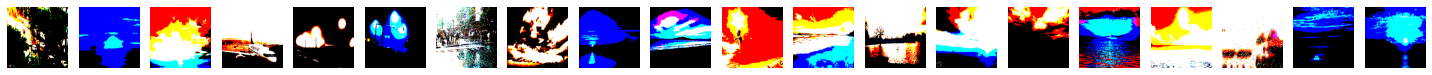

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 20, figsize = (20, 20))

for img, ax in zip(imgs, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [1]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def image_generation(pre, train):
#     train_datagen = ImageDataGenerator(preprocessing_function = pre, validation_split = 0.15)
    
#     train_gen = train_datagen.flow_from_dataframe(
#                                                     dataframe=train,
#                                                     x_col='file_path',
#                                                     y_col='labels',
#                                                     target_size=(100,100),
#                                                     class_mode='categorical',
#                                                     batch_size=32,
#                                                     shuffle=True,
#                                                     seed=0,
        
#                                                     subset='training',
        
#                                                     rotation_range=30,
#                                                     zoom_range=0.15,
#                                                     width_shift_range=0.2,
#                                                     height_shift_range=0.2,
#                                                     shear_range=0.15,
#                                                     horizontal_flip=True,
#                                                     fill_mode="nearest"
#                                                 ) 
    
#     valid_gen = train_datagen.flow_from_dataframe(
#                                                     dataframe=train,
#                                                     x_col='file_path',
#                                                     y_col='labels',
#                                                     target_size=(100,100),
#                                                     class_mode='categorical',
#                                                     batch_size=32,
#                                                     shuffle=False,
#                                                     seed=0,
        
#                                                     subset='validation',
        
#                                                     rotation_range=30,
#                                                     zoom_range=0.15,
#                                                     width_shift_range=0.2,
#                                                     height_shift_range=0.2,
#                                                     shear_range=0.15,
#                                                     horizontal_flip=True,
#                                                     fill_mode="nearest"
#                                                 )
    
#     return train_gen, valid_gen

## Constructing model with pre-trained model as the non-trainable part

In [11]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top = False, pooling = 'avg', input_shape = (224, 224, 3))

In [12]:
type(vgg16)

keras.engine.functional.Functional

In [13]:
vgg16.trainable = False

vgg16.summary()

In [14]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import models

model = models.Sequential()
model.add(vgg16)
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 14,780,997
Trainable params: 66,309
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# callbacks  = [EarlyStopping(monitor = 'val_loss',
#                             min_delta = 0,
#                             patience = 2,
#                             mode = 'auto'
#                             )]

In [ ]:
model.fit(x = train_datagen,
          validation_data = val_datagen, 
          epochs = 1, 
          # steps_per_epoch = 42, 
          # callbacks = callbacks,
          verbose = 2
         )

In [5]:
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.applications.vgg19 import preprocess_input

# VGG19_preprocess = preprocess_input

# train_gen_VGG19, valid_gen_VGG19 = image_generation(VGG19_preprocess, train_df)

## Classification on test data

In [ ]:
testing_set = pd.read_csv('Testing_set.csv')

filename =  testing_set['filename'].values.tolist()

Testing_folder =  'test'
file_path = []

for dirc in filename:
    file = os.path.join(Testing_folder, dirc)
    file_path.append(file)
    
pred_image_data = pd.DataFrame({'file_path': file_path})

In [ ]:
pred_datagen = ImageDataGenerator(preprocessing_function = VGG16_preprocess)\
                                   .flow_from_dataframe(dataframe = pred_image_data, 
                                                        x_col = 'file_path',  
                                                        class_mode = None,
                                                        target_size = (224, 224), 
                                                        batch_size = 20, 
                                                        seed = 6
                                                        )

In [ ]:
import numpy as np 

predictions = model.predict(pred_datagen)
predictions = np.argmax(predictions, axis = 1)

In [ ]:
predictions[:5]

In [ ]:
labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

In [ ]:
predictions[:5]

In [ ]:
predictions = pd.DataFrame(predictions)

predictions.columns = ['label']

predictions.to_csv('tf_keras_api_prediction_results.csv', index = False)

In [ ]:
predictions = pd.DataFrame(predictions)

predictions.columns = ['label']

predictions.to_csv('prediction_results.csv', index = False)